# LangGraph 教程 01：为聊天机器人添加工具 (Add Tools)

> 本教程基于 [LangGraph 官方教程 - Add Tools](https://langchain-ai.github.io/langgraph/tutorials/introduction/) 的中文翻译版本

## 📚 教程概述

为了处理聊天机器人无法从"记忆"中回答的查询，我们将集成一个网络搜索工具。聊天机器人可以使用这个工具来查找相关信息并提供更好的回应。

**注意**：本教程基于"构建基础聊天机器人"教程。

## 🎯 学习目标

- 理解如何为 LangGraph 聊天机器人集成外部工具
- 学习工具调用 (Tool Calling) 的概念和实现
- 掌握条件边 (Conditional Edges) 的使用
- 了解 LangGraph 预构建组件的使用

## 🔧 核心概念

- **工具 (Tools)**：外部功能，如网络搜索、计算器等
- **工具调用 (Tool Calling)**：LLM 决定何时使用工具的机制
- **条件边 (Conditional Edges)**：根据状态动态决定下一个节点
- **ToolNode**：处理工具调用的专用节点

## 📋 前置条件

在开始本教程之前，请确保您拥有：

1. **OpenRouter API Key**：用于访问 LLM 模型
2. **Tavily Search Engine API Key**：用于网络搜索工具

### 🔧 环境变量配置说明

如果您已经在 `.zshrc` 中配置了 API Keys，但 Jupyter 仍然要求输入，这是因为 Notebook 运行在独立的 Python 进程中。您可以：

1. **重启 Jupyter Notebook** 以重新加载环境变量
2. **或者直接在代码中设置**（下面的代码会自动处理）
3. **或者创建 `.env` 文件**（推荐方式）

## 1. 安装搜索引擎依赖

安装使用 Tavily 搜索引擎所需的依赖：

In [1]:
# 安装必要的依赖包
!pip install -U langchain-tavily LangGraph

  Using cached langchain_tavily-0.2.10-py3-none-any.whl.metadata (22 kB)
  Using cached langgraph-0.5.4-py3-none-any.whl.metadata (6.8 kB)
  Using cached langchain-0.3.26-py3-none-any.whl.metadata (7.8 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached langchain_text_splitters-0.3.8-py3-none-any.whl.metadata (1.9 kB)
  Using cached langsmith-0.4.8-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.1-

## 2. 配置环境变量

配置您的环境变量，包括搜索引擎 API Key 和 OpenRouter API Key。

### 💡 推荐方法：使用 .env 文件

项目中已提供 `.env.example` 模板文件，您可以：

1. **复制模板文件**：`cp .env.example .env`
2. **编辑 .env 文件**：填入您的实际 API Keys
3. **自动加载**：下面的代码会自动加载 .env 文件中的配置

### 🔧 手动配置方法

如果您没有使用 .env 文件，代码会提示您手动输入 API Keys。

In [2]:
import os
import getpass

# 🔄 尝试加载 .env 文件
print("🔍 检查 .env 文件...")
try:
    from dotenv import load_dotenv
    if load_dotenv():
        print("✅ .env 文件加载成功")
    else:
        print("📝 .env 文件不存在或为空")
except ImportError:
    print("💡 提示：安装 python-dotenv 可以自动加载 .env 文件")
    print("   pip install python-dotenv")

def _set_env(var: str):
    """智能地设置环境变量"""
    if os.environ.get(var):
        print(f"✅ {var} 已配置")
        return
    
    print(f"⚠️  {var} 未找到，请输入：")
    os.environ[var] = getpass.getpass(f"{var}: ")
    print(f"✅ {var} 设置完成")

# 检查并显示当前环境变量状态
print("\n🔍 检查环境变量状态:")
print(f"TAVILY_API_KEY: {'✅ 已设置' if os.environ.get('TAVILY_API_KEY') else '❌ 未设置'}")
print(f"OPENAI_API_KEY: {'✅ 已设置' if os.environ.get('OPENAI_API_KEY') else '❌ 未设置'}")

print("\n🔄 配置必要的环境变量...")

# 设置 Tavily API Key
_set_env("TAVILY_API_KEY")

# 设置 OpenRouter API Key
_set_env("OPENAI_API_KEY")

# 设置 OpenRouter 的 Base URL
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"

print("\n✅ 环境变量配置完成！")
print("🔗 使用 OpenRouter 作为 API 提供商")
print("🔍 使用 Tavily 作为搜索引擎")
print(f"📊 TAVILY_API_KEY: ...{os.environ.get('TAVILY_API_KEY', 'None')[-8:]}")
print(f"📊 OPENAI_API_KEY: ...{os.environ.get('OPENAI_API_KEY', 'None')[-8:]}")

🔍 检查 .env 文件...
💡 提示：安装 python-dotenv 可以自动加载 .env 文件
   pip install python-dotenv

🔍 检查环境变量状态:
TAVILY_API_KEY: ✅ 已设置
OPENAI_API_KEY: ✅ 已设置

🔄 配置必要的环境变量...
✅ TAVILY_API_KEY 已配置
✅ OPENAI_API_KEY 已配置

✅ 环境变量配置完成！
🔗 使用 OpenRouter 作为 API 提供商
🔍 使用 Tavily 作为搜索引擎
📊 TAVILY_API_KEY: ...rDpiRXfd
📊 OPENAI_API_KEY: ...1e2dcab1


## 3. 定义工具 (Define the Tool)

定义网络搜索工具：

In [3]:
from langchain_tavily import TavilySearch

# 创建 Tavily 搜索工具，限制返回最多 2 个结果
tool = TavilySearch(max_results=2)
tools = [tool]

print("🔍 搜索工具创建成功！")
print(f"工具名称: {tool.name}")
print(f"工具描述: {tool.description}")
tool.invoke("What's a 'node' in LangGraph?")


🔍 搜索工具创建成功！
工具名称: tavily_search
工具描述: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.


{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
   'title': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges',
   'content': 'Nodes: Perform the actual work. Nodes contain Python code that can execute any logic, from simple computations to LLM calls or integrations.',
   'score': 0.79254496,
   'raw_content': None},
  {'url': 'https://blog.langchain.dev/langgraph/',
   'title': 'LangGraph - LangChain Blog',
   'content': "TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent 

### 测试搜索工具

让我们测试一下搜索工具是否正常工作：

In [4]:
# 测试搜索工具
search_result = tool.invoke("What's a 'node' in LangGraph?")
print("🔍 搜索结果:")
print(f"查询: {search_result['query']}")
print(f"结果数量: {len(search_result['results'])}")
print("\n📄 搜索结果详情:")
for i, result in enumerate(search_result['results'], 1):
    print(f"\n{i}. {result['title']}")
    print(f"   URL: {result['url']}")
    print(f"   内容摘要: {result['content'][:200]}...")
    print(f"   相关度评分: {result['score']}")

🔍 搜索结果:
查询: What's a 'node' in LangGraph?
结果数量: 2

📄 搜索结果详情:

1. LangGraph Basics: Understanding State, Schema, Nodes, and Edges
   URL: https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5
   内容摘要: Nodes: Perform the actual work. Nodes contain Python code that can execute any logic, from simple computations to LLM calls or integrations....
   相关度评分: 0.79254496

2. LangGraph - LangChain Blog
   URL: https://blog.langchain.dev/langgraph/
   内容摘要: TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations...
   相关度评分: 0.7407191


## 4. 定义图结构 (Define the Graph)

为在第一个教程中创建的 StateGraph 添加 `bind_tools`。这让 LLM 知道如果它想使用搜索引擎，应该使用正确的 JSON 格式。

首先选择我们的 LLM：

In [5]:
!pip install -U "langchain[openai]"


  Using cached langchain_openai-0.3.28-py3-none-any.whl.metadata (2.3 kB)
  Using cached openai-1.97.0-py3-none-any.whl.metadata (29 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached langchain_openai-0.3.28-py3-none-any.whl (70 kB)
Using cached openai-1.97.0-py3-none-any.whl (764 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [langchain-openai][langchain-openai]


In [6]:
from langchain.chat_models import init_chat_model

# 🤖 选择和初始化 LLM 模型
# 这里我们使用 OpenRouter 来访问各种模型，避免网络访问问题

# 方式一：使用 GPT-4o（推荐，性能优秀）
llm = init_chat_model(
    "openai:openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1"
)

# 💡 其他可选模型（取消注释来使用）：

# 方式二：Claude 3.5 Sonnet（Anthropic 的顶级模型）
# llm = init_chat_model(
#     "openai:anthropic/claude-3.5-sonnet",
#     base_url="https://openrouter.ai/api/v1"
# )

# 方式三：Llama 3.1 405B（Meta 的开源大模型）
# llm = init_chat_model(
#     "openai:meta-llama/llama-3.1-405b-instruct",
#     base_url="https://openrouter.ai/api/v1"
# )

print("🤖 LLM 模型初始化成功！")
print("📡 使用 OpenRouter 访问 GPT-4o 模型")
print("🔧 模型支持工具调用 (Tool Calling) 功能")
llm.invoke("What's a 'node' in LangGraph?")

🤖 LLM 模型初始化成功！
📡 使用 OpenRouter 访问 GPT-4o 模型
🔧 模型支持工具调用 (Tool Calling) 功能


AIMessage(content='In LangGraph, a "node" typically refers to an individual component or element within a graph structure, particularly in the context of managing and processing data. Nodes can represent various entities, such as text inputs, functions, or other operations in a language processing workflow. \n\nEach node may have inputs and outputs connected to other nodes, creating a network that allows for complex interactions or transformations of data. This design often enables users to visualize and control the flow of language-related tasks, making it easier to develop and optimize processes like natural language understanding, generation, and analysis.\n\nIf you\'re looking for specific functionalities or details about how nodes operate within LangGraph, feel free to ask!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 16, 'total_tokens': 151, 'completion_tokens_details': None, 'prompt_tokens_details': None}, '

现在我们可以将其整合到 StateGraph 中：

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 定义状态类型
class State(TypedDict):
    messages: Annotated[list, add_messages]



LangGraph 中状态结构的定义详解

这段代码定义了 LangGraph 中图（graph）的**状态结构**，是构建聊天机器人或多步骤代理（agent）的**核心部分**。

简单来说，这段代码定义了一个名为 `State` 的数据结构。它必须包含一个叫做 `messages` 的键，该键的值是一个**列表**，并且这个列表会以**累加的方式**进行更新。

---

### 📦 代码分解

我们逐个分析每个部分：

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

#### ✅ `class State(TypedDict):`

- `TypedDict` 是 Python `typing` 模块中的一个功能，允许你创建带有**类型提示**的字典结构。
- 在 LangGraph 中，`State` 是在图的各个**节点之间传递的数据对象**。
- 这确保了你的状态始终是一个包含预定义键的字典，例如 `messages`。

---

#### ✅ `messages: ...`

- 在 `State` 类型中定义了一个键，名为 `messages`。
- 这个键通常用来**存储对话历史**，例如用户的输入和 AI 的回复。

---

#### ✅ `Annotated[list, add_messages]`

这是最关键的一行，它定义了 `messages` 的类型和更新方式：

- `list`：表示 `messages` 的值是一个列表。
- `Annotated`：Python 的类型提示增强工具，允许我们**给类型添加元数据**。
- `add_messages`：LangGraph 提供的一个**特殊函数（reducer）**，用于指示图如何更新 `messages` 列表。

---

### 🔁 核心功能：`add_messages`

`add_messages` 的作用是确保对话历史的**连续性**。

#### 🚫 没有 `add_messages` 时的情况：

- 初始状态：
  ```python
  {"messages": [HumanMessage("你好")]}
  ```

- 节点返回新消息：
  ```python
  [AIMessage("你好！有什么可以帮你的吗？")]
  ```

- 状态更新结果（**被覆盖**）：
  ```python
  {"messages": [AIMessage("你好！有什么可以帮你的吗？")]}
  ```

原始的人类消息 **被丢弃了**。

---

#### ✅ 使用 `add_messages` 时的情况：

- 初始状态：
  ```python
  {"messages": [HumanMessage("你好")]}
  ```

- 节点返回新消息：
  ```python
  [AIMessage("你好！有什么可以帮你的吗？")]
  ```

- 状态更新结果（**自动追加**）：
  ```python
  {"messages": [HumanMessage("你好"), AIMessage("你好！有什么可以帮你的吗？")]}
  ```

对话历史被**完整保留** ✅

---

## 总结 🧑‍💻

这段代码为 LangGraph 中的状态定义了一个清晰的蓝图：

- **结构**：状态是一个字典，包含 `messages` 键。
- **类型**：`messages` 是一个列表。
- **行为**：新消息将被**追加**到消息列表中，而不是替换掉原有内容。


In [8]:

# 创建图构建器
graph_builder = StateGraph(State)

# 🔧 修改：告诉 LLM 它可以调用哪些工具
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    """聊天机器人节点：处理用户消息并可能调用工具"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 添加聊天机器人节点
graph_builder.add_node("chatbot", chatbot)

print("📊 StateGraph 创建成功！")
print("🔧 LLM 已绑定工具，可以进行工具调用")

📊 StateGraph 创建成功！
🔧 LLM 已绑定工具，可以进行工具调用


## 5. 创建运行工具的函数

现在，创建一个函数来运行被调用的工具。通过添加工具到名为 `BasicToolNode` 的新节点来实现这一点，该节点检查状态中的最新消息，如果消息包含 `tool_calls`，则调用工具。

In [9]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """运行最后一条 AI 消息中请求的工具的节点"""

    def __init__(self, tools: list) -> None:
        # 创建工具名称到工具对象的映射
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """处理工具调用"""
        if messages := inputs.get("messages", []):
            message = messages[-1]  # 获取最后一条消息
        else:
            raise ValueError("在输入中没有找到消息")
        
        outputs = []
        # 处理消息中的每个工具调用
        for tool_call in message.tool_calls:
            # 调用相应的工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 创建工具消息
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# 创建工具节点
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

print("🛠️ BasicToolNode 创建成功！")
print("📝 注意: 在实际项目中，您可以使用 LangGraph 的预构建 ToolNode")

🛠️ BasicToolNode 创建成功！
📝 注意: 在实际项目中，您可以使用 LangGraph 的预构建 ToolNode


## 6. 定义条件边 (Define Conditional Edges)

添加工具节点后，现在可以定义条件边。

边路由控制流从一个节点到下一个节点。条件边从单个节点开始，通常包含"if"语句，根据当前图状态路由到不同的节点。

接下来，定义一个名为 `route_tools` 的路由函数，该函数检查聊天机器人输出中的 `tool_calls`。通过调用 `add_conditional_edges` 将此函数提供给图，告诉图每当聊天机器人节点完成时检查此函数以查看下一步去哪里。

条件将在存在工具调用时路由到工具，如果没有则路由到 END。由于条件可以返回 END，这次您不需要显式设置 `finish_point`。

### 🔄 工作流程说明

1. **用户输入** → `chatbot` 节点
2. **chatbot 处理**：
   - 如果需要工具 → 路由到 `tools` 节点
   - 如果可以直接回答 → 路由到 `END`
3. **tools 执行** → 返回到 `chatbot` 节点（形成循环）
4. **最终回复** → `END`

这种条件路由定义了主要的代理循环，使聊天机器人能够：
- 自主决定是否需要工具
- 执行多步骤推理
- 在获得足够信息后提供最终答案

In [10]:
def route_tools(state: State):
    """
    在条件边中使用，如果最后一条消息有工具调用，则路由到 ToolNode。
    否则，路由到结束。
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"在输入状态中没有找到消息: {state}")
    
    # 检查是否有工具调用
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print(f"🔧 检测到工具调用: {len(ai_message.tool_calls)} 个工具")
        return "tools"
    print("💬 无工具调用，直接回复")
    return END

# `tools_condition` 函数如果聊天机器人要求使用工具则返回 "tools"，
# 如果它可以直接回复则返回 "END"。这种条件路由定义了主要的代理循环。
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 以下字典让您告诉图将条件的输出解释为特定节点
    # 默认为恒等函数，但如果您想使用除了 "tools" 之外的其他名称的节点，
    # 您可以将字典的值更新为其他内容
    # 例如："tools": "my_tools"
    {"tools": "tools", END: END},
)

# 任何时候调用工具，我们都回到聊天机器人来决定下一步
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 编译图
graph = graph_builder.compile()

print("🎯 条件边配置完成！")
print("📊 图编译成功！")
print("\n🔄 工作流程:")
print("1. START → chatbot (处理用户输入)")
print("2. chatbot → tools (如果需要工具调用)")
print("3. tools → chatbot (工具执行完成后)")
print("4. chatbot → END (最终回复)")

🎯 条件边配置完成！
📊 图编译成功！

🔄 工作流程:
1. START → chatbot (处理用户输入)
2. chatbot → tools (如果需要工具调用)
3. tools → chatbot (工具执行完成后)
4. chatbot → END (最终回复)


## 7. 可视化图结构 (可选)

您可以使用 `get_graph` 方法和其中一种"绘制"方法来可视化图，如 `draw_ascii` 或 `draw_png`。

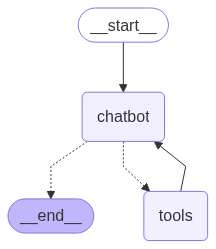

📊 图结构可视化显示成功！


In [11]:
from IPython.display import Image, display

# 尝试显示图的可视化
try:
    # 使用 Mermaid 绘制图
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("📊 图结构可视化显示成功！")
except Exception as e:
    # 如果无法绘制图像，显示 ASCII 版本
    print("⚠️ 无法显示图像，显示 ASCII 版本:")
    print(graph.get_graph().draw_ascii())
    print(f"\n🔧 提示: 要显示图像版本，需要安装额外依赖")
    print("错误信息:", str(e))

## 8. 询问机器人问题

现在您可以向聊天机器人询问其训练数据之外的问题：

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


💬 无工具调用，直接回复
Assistant: Hello! How can I assist you today?
Goodbye!


## 9. 使用预构建组件

为了便于使用，我们可以用 LangGraph 预构建组件替换自定义代码。这些组件具有内置功能，如并行 API 执行。

- `BasicToolNode` 被预构建的 `ToolNode` 替换
- `route_tools` 被预构建的 `tools_condition` 替换

In [13]:
!pip install -U langgraph.prebuilt

In [14]:
! pip show langgraph


Name: langgraph
Version: 0.5.4
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License-Expression: MIT
Location: /Users/zz/codes/langchain/.conda/lib/python3.11/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: 


In [15]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

print("🔄 使用预构建组件重新构建图...")

# 重新定义状态
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 创建新的图构建器
graph_builder_v2 = StateGraph(State)

# 重新创建工具和 LLM
tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    """聊天机器人节点：处理用户消息并可能调用工具"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 添加聊天机器人节点
graph_builder_v2.add_node("chatbot", chatbot)

# 🆕 使用预构建的 ToolNode
tool_node_v2 = ToolNode(tools=[tool])
graph_builder_v2.add_node("tools", tool_node_v2)

# 🆕 使用预构建的 tools_condition
graph_builder_v2.add_conditional_edges(
    "chatbot",
    tools_condition,  # 预构建的条件函数
)

# 添加边 # Any time a tool is called, we return to the chatbot to decide the next step

graph_builder_v2.add_edge("tools", "chatbot")
graph_builder_v2.add_edge(START, "chatbot")

# 编译图
graph_v2 = graph_builder_v2.compile()

print("✅ 使用预构建组件的图创建成功！")
print("🎯 主要改进:")
print("  - 使用 ToolNode 替代 BasicToolNode")
print("  - 使用 tools_condition 替代 route_tools")
print("  - 支持并行 API 执行")
print("  - 更强的错误处理")

🔄 使用预构建组件重新构建图...
✅ 使用预构建组件的图创建成功！
🎯 主要改进:
  - 使用 ToolNode 替代 BasicToolNode
  - 使用 tools_condition 替代 route_tools
  - 支持并行 API 执行
  - 更强的错误处理


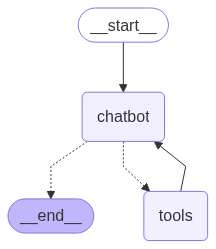

📊 图结构可视化显示成功！


In [17]:
from IPython.display import Image, display

# 尝试显示图的可视化
try:
    # 使用 Mermaid 绘制图
    display(Image(graph_v2.get_graph().draw_mermaid_png()))
    print("📊 图结构可视化显示成功！")
except Exception as e:
    # 如果无法绘制图像，显示 ASCII 版本
    print("⚠️ 无法显示图像，显示 ASCII 版本:")
    print(graph_v2.get_graph().draw_ascii())
    print(f"\n🔧 提示: 要显示图像版本，需要安装额外依赖")
    print("错误信息:", str(e))

In [18]:
# Test graph_v2 with a sample query
print("testing graph_v2 with a sample query")
for event in graph_v2.stream({"messages": [{"role": "user", "content": "What's the weather in KL malaysia?"}]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

testing graph_v2 with a sample query
Assistant: 
Assistant: {"query": "current weather Kuala Lumpur Malaysia", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Kuala Lumpur, Malaysia", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Kuala Lumpur', 'region': 'Kuala Lumpur', 'country': 'Malaysia', 'lat': 3.1667, 'lon': 101.7, 'tz_id': 'Asia/Kuala_Lumpur', 'localtime_epoch': 1753157039, 'localtime': '2025-07-22 12:03'}, 'current': {'last_updated_epoch': 1753156800, 'last_updated': '2025-07-22 12:00', 'temp_c': 26.1, 'temp_f': 79.0, 'is_day': 1, 'condition': {'text': 'Light rain', 'icon': '//cdn.weatherapi.com/weather/64x64/day/296.png', 'code': 1183}, 'wind_mph': 5.8, 'wind_kph': 9.4, 'wind_degree': 209, 'wind_dir': 'SSW', 'pressure_mb': 1010.0, 'pressure_in': 29.83, 'precip_mm': 0.01, 'precip_in': 0.0, 'humidity': 89, 'cloud': 25, 'feelslike_c': 26.7, 'feelslike_f': 80.1, 'windchill_c': 32.5, 'windchill_f': 90.5, 'heati

## 🎉 恭喜！

您已经在 LangGraph 中创建了一个会话代理，它可以在需要时使用搜索引擎检索最新信息。现在它可以处理更广泛的用户查询。

## 🔍 关键学习点

### 1. 工具集成 (Tool Integration)
- **工具定义**: 使用 `TavilySearch` 创建搜索工具
- **工具绑定**: 使用 `llm.bind_tools(tools)` 让 LLM 知道可用工具
- **工具调用**: LLM 自动决定何时使用工具

### 2. 条件路由 (Conditional Routing)
- **条件边**: 根据消息是否包含工具调用来路由
- **动态决策**: 图可以根据状态动态选择下一个节点
- **循环处理**: 工具 → 聊天机器人 → 可能更多工具

### 3. 预构建组件 (Prebuilt Components)
- **ToolNode**: 自动处理工具调用和结果
- **tools_condition**: 标准化的条件路由逻辑
- **并行执行**: 预构建组件支持更高效的执行

### 4. 错误处理和调试
- **消息验证**: 检查消息格式和工具调用
- **状态管理**: 正确处理图状态转换
- **流式输出**: 实时显示处理过程

## 🚀 下一步

聊天机器人本身无法记住过去的交互，这限制了它进行连贯的多轮对话的能力。在下一部分中，您将添加记忆功能来解决这个问题。

## 📚 扩展阅读

- [LangGraph Tools 文档](https://langchain-ai.github.io/langgraph/concepts/tools/)
- [Tavily Search API](https://tavily.com/)
- [OpenRouter 模型列表](https://openrouter.ai/models)
- [LangSmith 调试工具](https://smith.langchain.com/)

---

*📝 本教程是 LangGraph 学习系列的第二部分。继续关注后续教程，学习如何添加记忆功能、构建多智能体系统等高级功能。*